# One-dimensional Polynomial Chaos

Here we will demonstrate a 1D PCE approach, using a simple scalar analytic test function $f(x)$, defined as:

\begin{align}
 f(x) = \exp\left[2x + \sin(x)\right]
\end{align}

where $x\sim\mathcal{U}[-1, 1]$.

In [1]:
# uncomment to install missing libraries
#!pip install numpy
#!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Legendre, HermiteE, Hermite

In [3]:
def f(x):
    """
    Our analytic test function

    Parameters
    ----------
    x : float, or array of floats
        The input x.

    Returns
    -------
    f(x) : float, or array of floats
        The output f(x).

    """

    return np.exp(2*x + np.sin(4*x))
    #return np.exp(np.abs(2*x) + 100*np.abs(np.sin(4*x)))
    #return np.abs(x)

There are 2 sources of error in our PCE

* the truncation of the PCE expansion (regulated by`N`)
* the error in the quadrature approximation of $\mathbb{E}[f\phi_j]$, $j=1,\cdots,N$ (regulated by `Q`)

In [4]:
# number of terms in the PC expansion
N = 10
# number of Quadrature points
Q = N

Since $x$ is uniformly distributed, we know already that the orthonormal basis consists of Legendre polynomials. We will therefore use a Gaussian quadrature rule for Legendre polynomials to compute the PCE coefficients. The standard Numpy subroutine for this is [leggauss](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.legendre.leggauss.html): 

![](./images/np_leggauss.png)

In [5]:
# compute Gaussian quadrature rule for Legendre polynomials    
x_k, w_k = np.polynomial.legendre.leggauss(Q)
print(np.sum(w_k))

2.0


We summed the quadrature weights, and find they sum to 2. **Is this a problem**?

Yes, it is: 

\begin{align}
 1 = \int p(x)\mathrm{d}x = \sum_k w_k
\end{align}

The sum of the weights is the quadrature approximation of the integrated probability density function, which should equal 1. If you are going to use standard built-in subroutines for quadrature or orthogonal polynomials, you'll often find a "physicist" version, which has the wrong weight function for our purpose. `np.polynomial.legendre.leggauss` has a weight function of 1 (see figure above), which integrates to 2 over $x\in[-1,1]$. What we require is a "probabilists" version, with a weight function of $1/2$ (since $\mathcal{U}[-1,1] = 1/2$ for $x\in[-1,1]$).

An easy fix is to just multiply the weights by 0.5. If you do not do so the results will be incorrect.

In [6]:
# weight function is 1, rescale to get weight function 1/2
w_k *= 0.5

**What if our code takes an input $x\sim\mathcal{U}[0,1]$ instead of $x\sim\mathcal{U}[-1,1]$?**

The `leggauss` subroutine only generates a rule over $[-1,1]$. If you require another domain, you could:

1) keep using `leggauss` and apply a simple linear transformation, in this case `x = 0.5*x + 1` inside your code, compute all PCE results over $[-1,1]$.
2) do not use `leggauss`, and use a tool that can generate a quadrature rule and an orthogonal basis based on a user specified input distribution, e.g. `chaospy`.

### Computing the PCE coefficients

Remember, the PCE coefficients are given by

\begin{align}
\boxed{\hat{f}_i = \frac{\mathbb{E}[f\phi_i]}{\gamma_i}} \approx \frac{\sum_k f(x_k)\phi_i(x_k)w_k}{\sum_k \phi_i(x_k)\phi_i(x_k) w_k}, \quad i=1,\cdots,N.
\end{align}

In [7]:
def get_pce_coefs(N, Q):
    """
    Compute the PCE coefficients for a PCE expansion of N terms, using a
    Q-point Legendre-Gauss quadrature rule.

    Parameters
    ----------
    N : integer
        The number of PCE terms.
    Q : integer
        The number of quadrature points.

    Returns
    -------
    pce_coefs : array
        N PCE coefficients.
    gamma : array
        N normalization coefficients gamma_i
    n_samples : int
        The number of model evaluations.

    """

    # get the quad rule, correct for wrong weight
    x_k, w_k = np.polynomial.legendre.leggauss(Q)
    w_k *= 0.5

    # evaluate 'code' at quadrature points
    f_k = f(x_k)

    pce_coefs = np.zeros(N)
    gamma = np.zeros(N)
    for i in range(N):
        # numerator
        num = np.sum(f_k * Legendre.basis(i)(x_k) * w_k)
        # denominator
        gamma[i] = np.sum(Legendre.basis(i)(x_k) * Legendre.basis(i)(x_k) * w_k)
        pce_coefs[i] = num / gamma[i]

    # number of code evaluations
    n_samples = x_k.size

    return pce_coefs, gamma, n_samples

In [8]:
pce_coefs, gamma, _ = get_pce_coefs(N, Q)
print('PCE coefficients: %s \nNormalization constants: %s' % (pce_coefs, gamma))

PCE coefficients: [ 2.40723831  3.56032531  0.31905417 -2.78316869 -1.9035646   0.59779651
  1.49640846  0.55497545 -0.52586727 -0.63746663] 
Normalization constants: [1.         0.33333333 0.2        0.14285714 0.11111111 0.09090909
 0.07692308 0.06666667 0.05882353 0.05263158]


### Mean and variance

With the $\hat{f}_i$ known, the mean and variance of $f$ (due to uncertainty in $x$) are easily computed:

\begin{align*}
\boxed{
\mathbb{E}[f] = \hat{f}_0, \quad
\mathbb{V}\mathrm{ar}[f] = \sum_{i=1}\hat{f}^2_i\gamma_i}
\end{align*}

Note that we must skip the $i=0$ index in the variance summation.

In [9]:
def get_mean_var(pce_coefs, gamma):
    """
    Compute the PCE mean and variance.

    Parameters
    ----------
    pce_coefs : array
        The PCE coefficients.
    gamma : array
        The normalization constants gamma_i.

    Returns
    -------
    mean : float
        The estimated mean of f(x).
    var : float
        The estimated variance of f(x).

    """

    mean = pce_coefs[0]
    var = np.sum(pce_coefs[1:] ** 2 * gamma[1:])
    
    return mean, var

In [10]:
get_mean_var(pce_coefs, gamma)

(2.407238314030189, 6.017781572232778)

### MC vs PCE convergence

Below we compute the mean and standard deviation for an increasing number of PCE expansion terms. We also compute the same quantities using MC sampling, for a much larger range of code evaluations.

For MC sampling we repeat the experiment 50 times at each sampling size, as the computed mean and variance are random variables themselves due to sampling error. This is not the case for PCE. Once $p(x)$ has been chosen, the procedure is deterministic. This is because in PCE the sampling is not stochastic, the model is evaluated at the (non-random) points of the quadrature rule.

In [11]:
# PCE computation
# N = 1, 2, 3, ....
N_range = np.arange(1, 100)
mu_pce = np.zeros(N_range.size)
sigma_pce = np.zeros(N_range.size)
n_pce = np.zeros(N_range.size)

# compute moments for different N
for count, n in enumerate(N_range):
    pce_coefs, gamma, n_pce[count] = get_pce_coefs(n, n)
    mu_pce[count], sigma_pce[count] = get_mean_var(pce_coefs, gamma)

# var -> stddev
sigma_pce = np.sqrt(sigma_pce)

In [12]:
# compute the mean and variance via MC
n_mc = [1, 10, 100, 1000, 10000, 100000, 1000000]

# MC moment estimates are random variables, repeat the calulations n_repeat times
n_repeat = 50

mu_mc = np.zeros([len(n_mc), n_repeat])
sigma_mc = np.zeros([len(n_mc), n_repeat])

for i, n in enumerate(n_mc):
    for j in range(n_repeat):
        x = np.random.rand(n) * 2 - 1
        samples = f(x)
        mu_mc[i, j] = np.mean(samples)
        sigma_mc[i, j] = np.std(samples)

Plot the PCE and MC results.

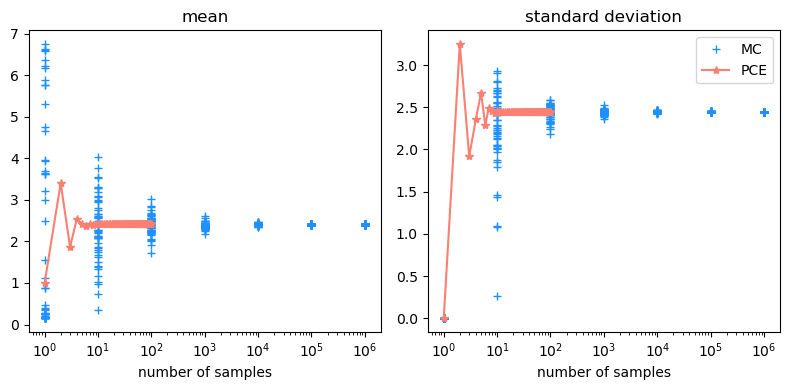

In [13]:
fig = plt.figure(figsize=[8, 4])
ax1 = fig.add_subplot(121, xscale='log', yscale='linear', title='mean', xlabel='number of samples')
ax2 = fig.add_subplot(122, xscale='log', yscale='linear', title='standard deviation', xlabel='number of samples')

ax1.plot(n_mc, mu_mc, '+', color='dodgerblue')
ax1.plot(n_pce, mu_pce * np.ones(len(n_pce)), '-*', color='salmon')

ax2.plot(n_mc, sigma_mc, '+', color='dodgerblue', label='MC')
ax2.plot(n_pce, sigma_pce, '-*', color='salmon', label='PCE')

# remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()

plt.show()

### Surrogate model

Note that the PCE expansion:

\begin{align*}
\boxed{
f(x) = \sum_{i=0}^N\hat{f}_i\phi_i(x)}
\end{align*}

is a **surrogate model** of the computer code $f(x)$. If $f(x)$ is computationally expensive, it can take a long time to compute the $\hat{f}_i$. Once this is done however, the expansion can be evaluated many times in a fraction of a second. It is a surrogate model, a fast approximation of the real computer model.

We do so we need the evalate the basis functions $\phi_i$ at random locations $x$. This is easy as they are just polynomials in the stochastic space $x$. Here we plot the first few Legendre polynomials:

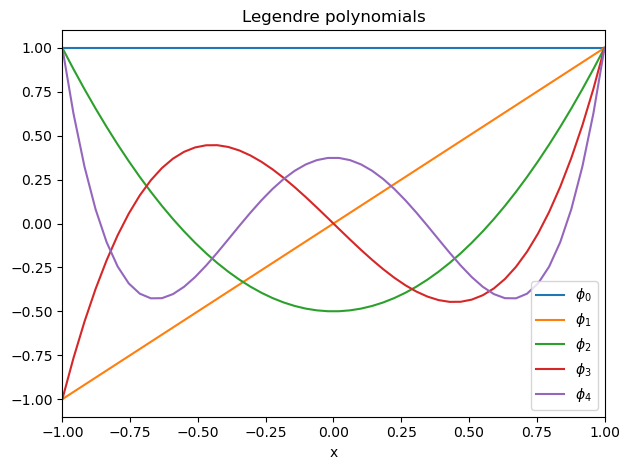

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', xlim=[-1,1], title='Legendre polynomials')

X = np.linspace(-1, 1, 50)

for i in range(5):
    ax.plot(X, Legendre.basis(i)(X), label=r'$\phi_%d$' % i)

plt.legend()
plt.tight_layout()

Below we compute the surrogate model for various $N$:

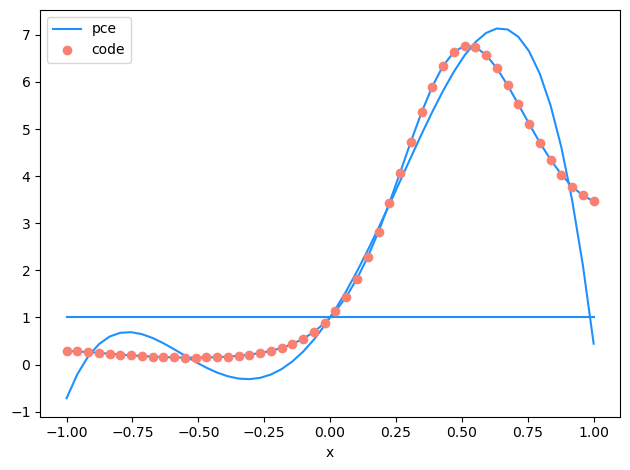

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x')

N_range = [1, 5, 200]

for n in N_range:
    surr = 0.
    pce_coefs, _, _ = get_pce_coefs(n, n)
    for i in range(n):
        surr += pce_coefs[i] * Legendre.basis(i)(X)
    ax.plot(X, surr, color='dodgerblue', label='pce')

ax.plot(X, f(X), 'o', color = 'salmon', label='code')

# remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
